In [2]:
import os
import sys
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill
import seaborn as sns
import zipfile

plt.style.use("default")

In [3]:
SESSION_FILE = "session.dill"

In [4]:
# if os.path.exists(SESSION_FILE):
#     with open(SESSION_FILE, "rb") as f:
#         session = dill.load(f)

In [5]:
class Dataset:
    def __init__(self, name="Leukemia_GSE28497.csv",
                 url="https://sbcb.inf.ufrgs.br/data/cumida/Genes/Leukemia/GSE28497/"):
        self.filepath = name
        if not os.path.exists(self.filepath):
            print(f"Downloading dataset {name}...", file=sys.stderr)
            urllib.request.urlretrieve(url + name, filename=name)
        self.load_dataset()

    def load_dataset(self):
        # Load the dataset
        self.data = pd.read_csv(self.filepath)
        print(self.data.head())
        self.data.set_index(self.data.columns[0], inplace=True) #As it is a human identifier, can use it as ind
        self.data['type'], self.label_mapping = pd.factorize(self.data['type'])

    def get_label_mapping(self):
        return self.label_mapping


In [6]:
dataset = Dataset()

            samples        type  1007_s_at   1053_at    117_at    121_at  \
0  GSM705467.CEL.gz  B-CELL_ALL   7.409521  5.009216  4.173607  7.315369   
1  GSM705468.CEL.gz  B-CELL_ALL   7.177109  5.415108  4.426778  7.550818   
2  GSM705469.CEL.gz  B-CELL_ALL   6.564918  5.248020  4.252414  7.175169   
3  GSM705470.CEL.gz  B-CELL_ALL   6.872028  5.155963  4.388849  7.365933   
4  GSM705471.CEL.gz  B-CELL_ALL   7.402105  5.509826  4.284291  7.214947   

   1255_g_at   1294_at   1316_at   1320_at  ...  AFFX-r2-Hs28SrRNA-5_at  \
0   3.185411  7.620644  3.731541  3.471587  ...                2.968822   
1   3.134181  7.685723  3.907953  3.650995  ...                2.982888   
2   3.017718  7.956261  3.354557  3.302989  ...                2.897425   
3   3.031735  7.830002  3.508926  3.412491  ...                3.024722   
4   2.925269  7.789838  3.610425  3.362593  ...                3.259802   

   AFFX-r2-Hs28SrRNA-M_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
0                3.22

In [7]:
print(dataset.data.columns)

Index(['type', '1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at',
       '1294_at', '1316_at', '1320_at', '1405_i_at',
       ...
       'AFFX-r2-Hs28SrRNA-5_at', 'AFFX-r2-Hs28SrRNA-M_at',
       'AFFX-r2-P1-cre-3_at', 'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at',
       'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at',
       'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at'],
      dtype='object', length=22284)


In [8]:
print(dataset.data.head())

                  type  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
samples                                                                      
GSM705467.CEL.gz     0   7.409521  5.009216  4.173607  7.315369   3.185411   
GSM705468.CEL.gz     0   7.177109  5.415108  4.426778  7.550818   3.134181   
GSM705469.CEL.gz     0   6.564918  5.248020  4.252414  7.175169   3.017718   
GSM705470.CEL.gz     0   6.872028  5.155963  4.388849  7.365933   3.031735   
GSM705471.CEL.gz     0   7.402105  5.509826  4.284291  7.214947   2.925269   

                   1294_at   1316_at   1320_at  1405_i_at  ...  \
samples                                                    ...   
GSM705467.CEL.gz  7.620644  3.731541  3.471587   4.167374  ...   
GSM705468.CEL.gz  7.685723  3.907953  3.650995   3.860015  ...   
GSM705469.CEL.gz  7.956261  3.354557  3.302989   3.335324  ...   
GSM705470.CEL.gz  7.830002  3.508926  3.412491   3.439769  ...   
GSM705471.CEL.gz  7.789838  3.610425  3.362593   3.412095

In [9]:
print(dataset.get_label_mapping())
# ? What do these classes represent?

Index(['B-CELL_ALL', 'B-CELL_ALL_TCF3-PBX1', 'B-CELL_ALL_HYPERDIP',
       'B-CELL_ALL_HYPO', 'B-CELL_ALL_MLL', 'B-CELL_ALL_T-ALL',
       'B-CELL_ALL_ETV6-RUNX1'],
      dtype='object')


## Class imbalance

In [10]:
for cls, cnt in zip(dataset.get_label_mapping(), dataset.data["type"].value_counts()):
    print(f"{cls}: {cnt}")

B-CELL_ALL: 74
B-CELL_ALL_TCF3-PBX1: 53
B-CELL_ALL_HYPERDIP: 51
B-CELL_ALL_HYPO: 46
B-CELL_ALL_MLL: 22
B-CELL_ALL_T-ALL: 18
B-CELL_ALL_ETV6-RUNX1: 17


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = dataset.data.drop('type', axis=1)  # features
y = dataset.data['type']  # target

In [13]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

## Models

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.base

In [15]:
import numpy as np
import seaborn as sns


def train_and_evaluate_model(
    model: sklearn.base.BaseEstimator,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> tuple[np.ndarray, str, np.ndarray, str]:
    # Train the model using cross-validation
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)

    # Evaluate the model on training data
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(
        y_train,
        y_train_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    # Evaluate the model on validation data
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(
        y_test,
        y_test_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    return (
        train_confusion_matrix,
        train_classification_report,
        test_confusion_matrix,
        test_classification_report,
    )


def plot_confusion_matrix_and_report(
    train_confusion_matrix: np.ndarray,
    train_classification_report: str,
    test_confusion_matrix: np.ndarray,
    test_classification_report: str,
    estimator_name: str,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot confusion matrix for train data
    sns.heatmap(
        train_confusion_matrix, annot=True, fmt="d", ax=axs[0]
    )
    axs[0].set_title(f"Train Confusion Matrix ({estimator_name})")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # Plot confusion matrix for test data
    sns.heatmap(test_confusion_matrix, annot=True, fmt="d", ax=axs[1])
    axs[1].set_title(f"Test Confusion Matrix ({estimator_name})")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print(f"{estimator_name} (Train) Classification Report:")
    print(train_classification_report)

    print("========================================")

    print(f"{estimator_name} (Test) Classification Report:")
    print(test_classification_report)


In [16]:
MLP = MLPClassifier(
    hidden_layer_sizes=(100,),
    learning_rate_init=0.3,
    momentum=0.2,
    max_iter=500,
    random_state=random_seed,
    verbose=True,
)
KNN = KNeighborsClassifier(n_neighbors=5)

# MLP

In [17]:
(
    MLP_train_confusion_matrix,
    MLP_train_classification_report,
    MLP_test_confusion_matrix,
    MLP_test_classification_report,
) = train_and_evaluate_model(MLP, X_train, y_train, X_test, y_test)

Iteration 1, loss = 9.01095941
Iteration 2, loss = 29.27743394
Iteration 3, loss = 33.64673152
Iteration 4, loss = 24.98294053
Iteration 5, loss = 3.20496779
Iteration 6, loss = 3.33986260
Iteration 7, loss = 3.44993487
Iteration 8, loss = 3.57581643
Iteration 9, loss = 3.72716241
Iteration 10, loss = 3.88700365
Iteration 11, loss = 4.05193621
Iteration 12, loss = 4.20712906
Iteration 13, loss = 4.33522997
Iteration 14, loss = 4.44027065
Iteration 15, loss = 4.52676035
Iteration 16, loss = 4.59488101
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 9.01095941
Iteration 2, loss = 29.27743394
Iteration 3, loss = 33.64673152
Iteration 4, loss = 24.98294053
Iteration 5, loss = 3.20496779
Iteration 6, loss = 3.33986260
Iteration 7, loss = 3.44993487
Iteration 8, loss = 3.57581643
Iteration 9, loss = 3.72716241
Iteration 10, loss = 3.88700365
Iteration 11, loss = 4.05193621
Iteration 12, loss = 4.20712906
Iteration 13, loss = 4.335

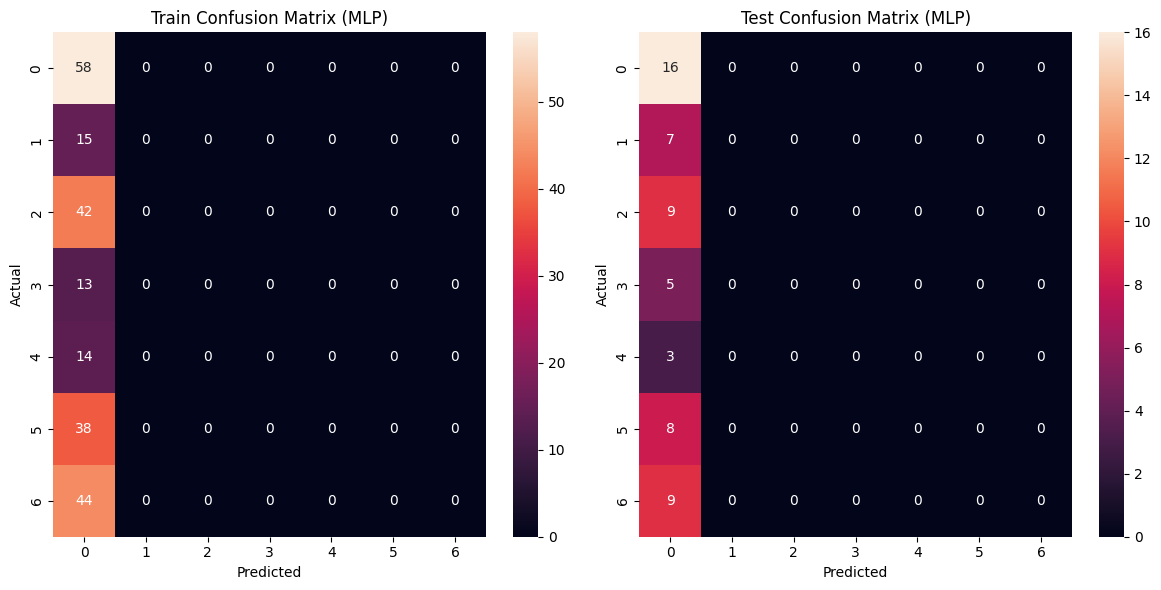

MLP (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.26      1.00      0.41        58
 B-CELL_ALL_TCF3-PBX1       1.00      0.00      0.00        15
  B-CELL_ALL_HYPERDIP       1.00      0.00      0.00        42
      B-CELL_ALL_HYPO       1.00      0.00      0.00        13
       B-CELL_ALL_MLL       1.00      0.00      0.00        14
     B-CELL_ALL_T-ALL       1.00      0.00      0.00        38
B-CELL_ALL_ETV6-RUNX1       1.00      0.00      0.00        44

             accuracy                           0.26       224
            macro avg       0.89      0.14      0.06       224
         weighted avg       0.81      0.26      0.11       224

MLP (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.28      1.00      0.44        16
 B-CELL_ALL_TCF3-PBX1       1.00      0.00      0.00         7
  B-CELL_ALL_HYPERDIP       1.00      0.00   

In [18]:
plot_confusion_matrix_and_report(
    MLP_train_confusion_matrix, MLP_train_classification_report,
    MLP_test_confusion_matrix, MLP_test_classification_report,
    "MLP"
)

# KNN

In [19]:
(
    KNN_train_confusion_matrix,
    KNN_train_classification_report,
    KNN_test_confusion_matrix,
    KNN_test_classification_report,
) = train_and_evaluate_model(KNN, X_train, y_train, X_test, y_test)

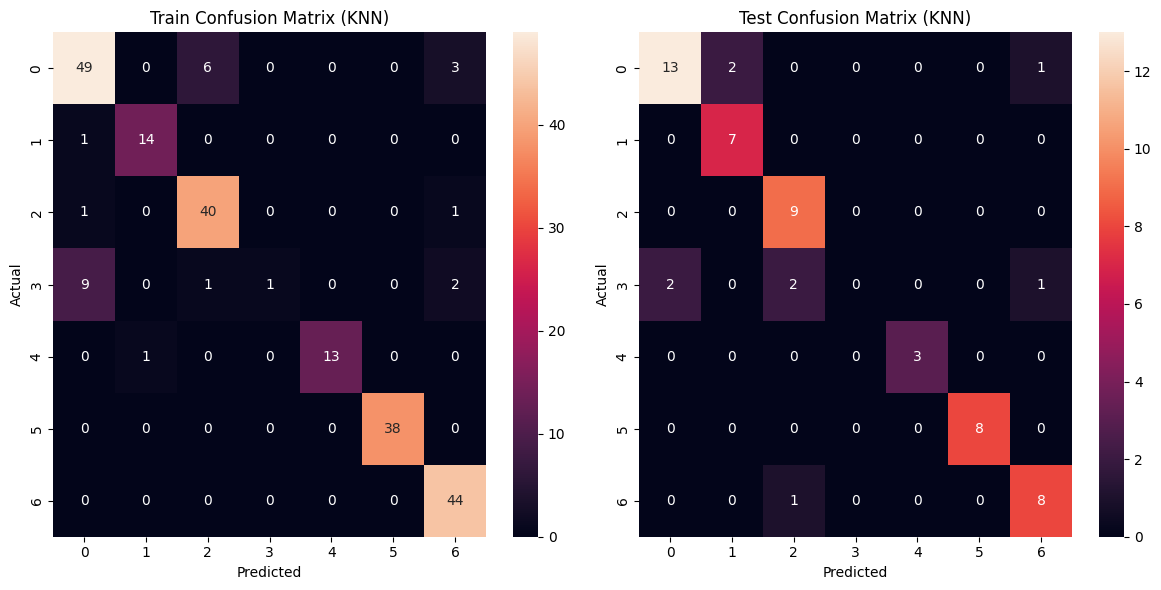

KNN (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.82      0.84      0.83        58
 B-CELL_ALL_TCF3-PBX1       0.93      0.93      0.93        15
  B-CELL_ALL_HYPERDIP       0.85      0.95      0.90        42
      B-CELL_ALL_HYPO       1.00      0.08      0.14        13
       B-CELL_ALL_MLL       1.00      0.93      0.96        14
     B-CELL_ALL_T-ALL       1.00      1.00      1.00        38
B-CELL_ALL_ETV6-RUNX1       0.88      1.00      0.94        44

             accuracy                           0.89       224
            macro avg       0.93      0.82      0.81       224
         weighted avg       0.90      0.89      0.87       224

KNN (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.87      0.81      0.84        16
 B-CELL_ALL_TCF3-PBX1       0.78      1.00      0.88         7
  B-CELL_ALL_HYPERDIP       0.75      1.00   

In [20]:
plot_confusion_matrix_and_report(
    KNN_train_confusion_matrix, KNN_train_classification_report,
    KNN_test_confusion_matrix, KNN_test_classification_report,
    "KNN"
)

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
DT = DecisionTreeClassifier(random_state=42)
LR = LogisticRegression(random_state=42, max_iter=1000)

# Decision tree

In [23]:
(DT_train_confusion_matrix, DT_train_classification_report, DT_test_confusion_matrix,
DT_test_classification_report,) = train_and_evaluate_model(
    model=DT,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
    )

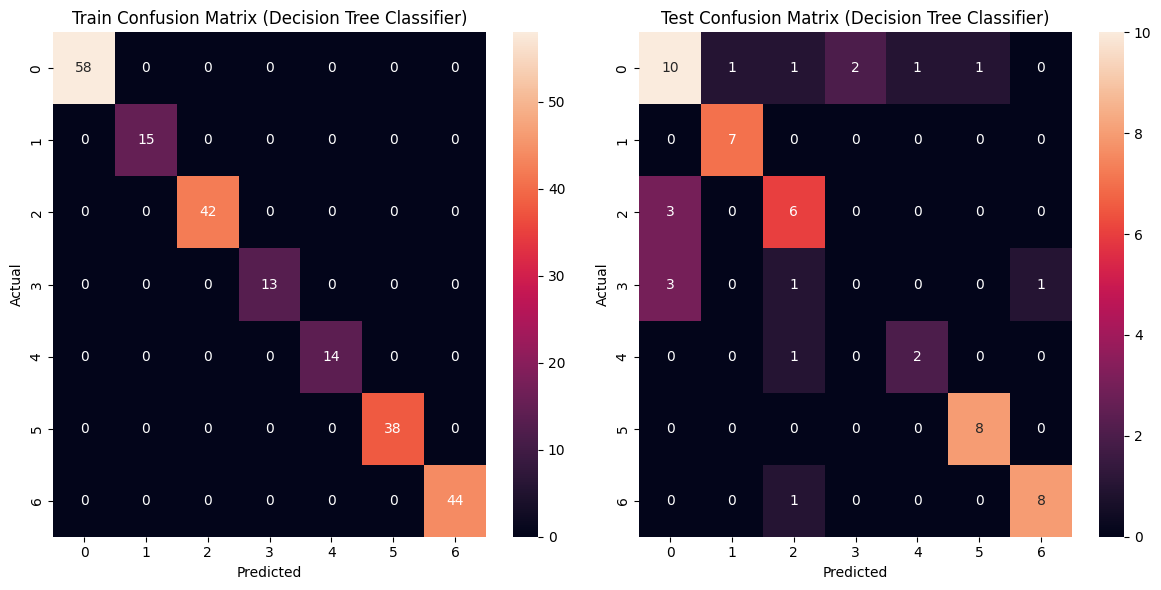

Decision Tree Classifier (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       1.00      1.00      1.00        58
 B-CELL_ALL_TCF3-PBX1       1.00      1.00      1.00        15
  B-CELL_ALL_HYPERDIP       1.00      1.00      1.00        42
      B-CELL_ALL_HYPO       1.00      1.00      1.00        13
       B-CELL_ALL_MLL       1.00      1.00      1.00        14
     B-CELL_ALL_T-ALL       1.00      1.00      1.00        38
B-CELL_ALL_ETV6-RUNX1       1.00      1.00      1.00        44

             accuracy                           1.00       224
            macro avg       1.00      1.00      1.00       224
         weighted avg       1.00      1.00      1.00       224

Decision Tree Classifier (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.62      0.62      0.62        16
 B-CELL_ALL_TCF3-PBX1       0.88      1.00      0.93         7
  B

In [24]:
plot_confusion_matrix_and_report(
    train_confusion_matrix=DT_train_confusion_matrix,
    train_classification_report=DT_train_classification_report,
    test_confusion_matrix=DT_test_confusion_matrix,
    test_classification_report=DT_test_classification_report,
    estimator_name="Decision Tree Classifier"
)

# Logistic regression

In [25]:
(LR_train_confusion_matrix, LR_train_classification_report, LR_test_confusion_matrix,
LR_test_classification_report,) = train_and_evaluate_model(
    model=LR,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test
    )

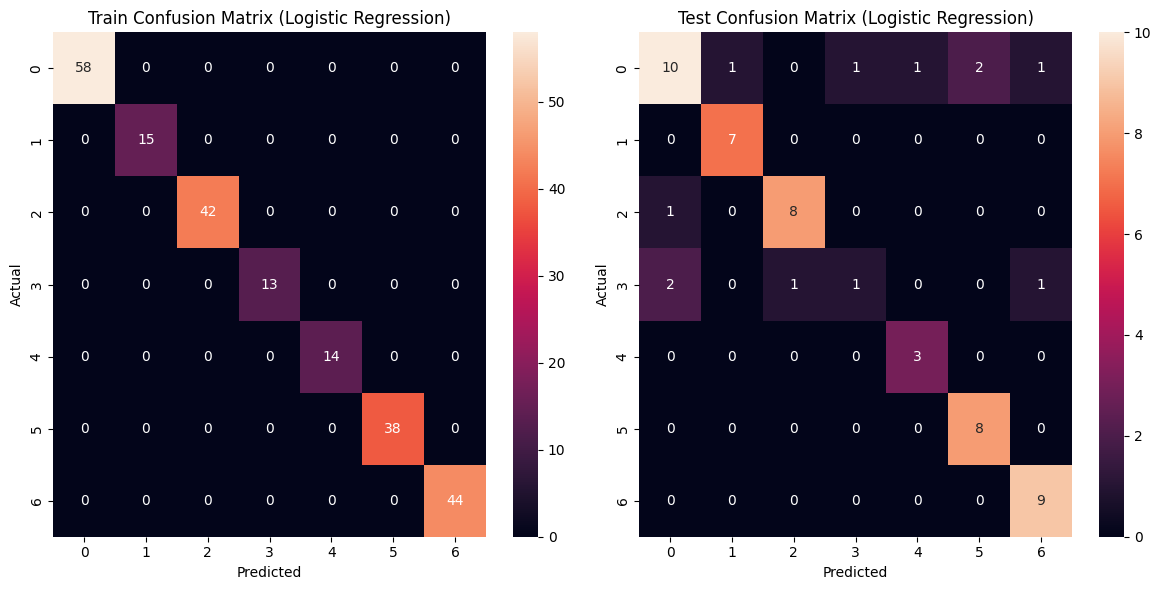

Logistic Regression (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       1.00      1.00      1.00        58
 B-CELL_ALL_TCF3-PBX1       1.00      1.00      1.00        15
  B-CELL_ALL_HYPERDIP       1.00      1.00      1.00        42
      B-CELL_ALL_HYPO       1.00      1.00      1.00        13
       B-CELL_ALL_MLL       1.00      1.00      1.00        14
     B-CELL_ALL_T-ALL       1.00      1.00      1.00        38
B-CELL_ALL_ETV6-RUNX1       1.00      1.00      1.00        44

             accuracy                           1.00       224
            macro avg       1.00      1.00      1.00       224
         weighted avg       1.00      1.00      1.00       224

Logistic Regression (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.77      0.62      0.69        16
 B-CELL_ALL_TCF3-PBX1       0.88      1.00      0.93         7
  B-CELL_ALL_

In [26]:
plot_confusion_matrix_and_report(
    train_confusion_matrix=LR_train_confusion_matrix,
    train_classification_report=LR_train_classification_report,
    test_confusion_matrix=LR_test_confusion_matrix,
    test_classification_report=LR_test_classification_report,
    estimator_name="Logistic Regression"
)

# Identifying class imbalance

type
0    74
6    53
2    51
5    46
1    22
3    18
4    17
Name: count, dtype: int64


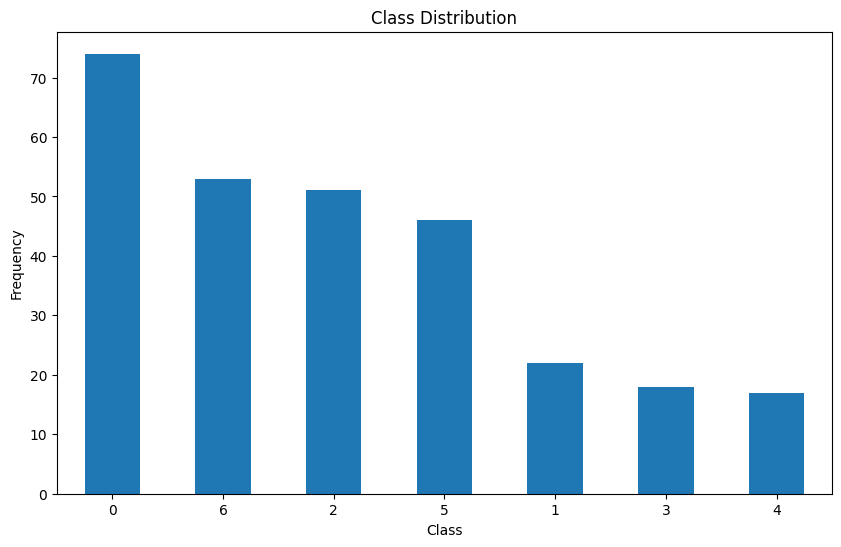

In [27]:
import matplotlib.pyplot as plt

class_counts = y.value_counts()
print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Dealing with Imbalance

### SMOTE

type
0    74
1    74
2    74
3    74
4    74
5    74
6    74
Name: count, dtype: int64


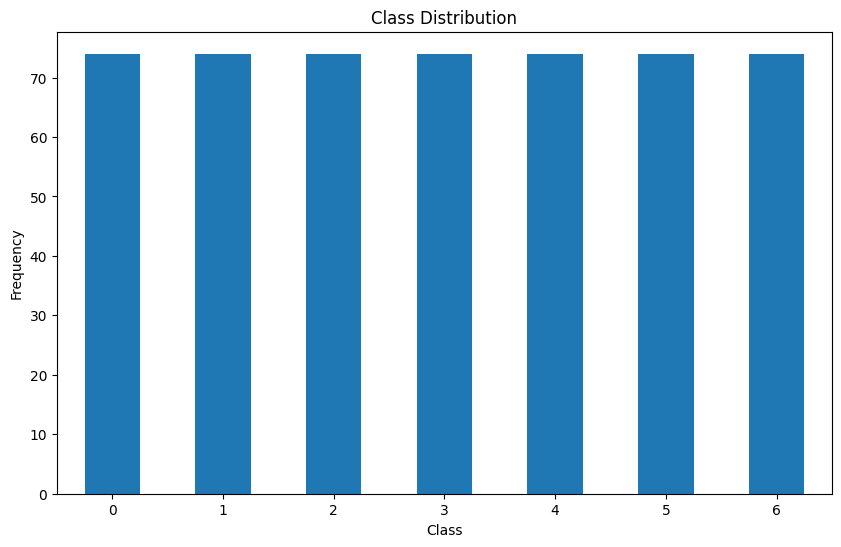

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smoted, y_smoted = smote.fit_resample(X, y)

class_counts = y_smoted.value_counts()
print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

### Random Oversampling

type
0    74
1    74
2    74
3    74
4    74
5    74
6    74
Name: count, dtype: int64


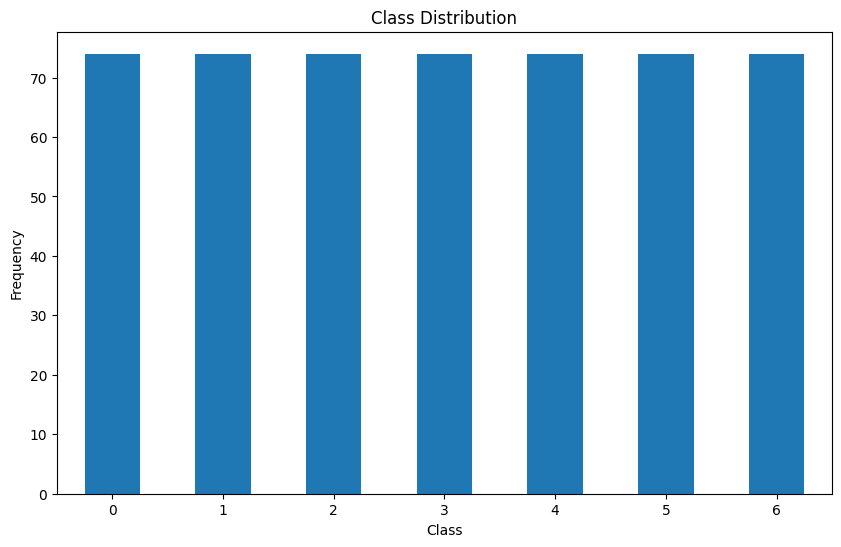

In [29]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_OverResampled, y_OverResampled = ros.fit_resample(X, y)

class_counts = y_OverResampled.value_counts()
print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

### Random Undersampling

type
0    17
1    17
2    17
3    17
4    17
5    17
6    17
Name: count, dtype: int64


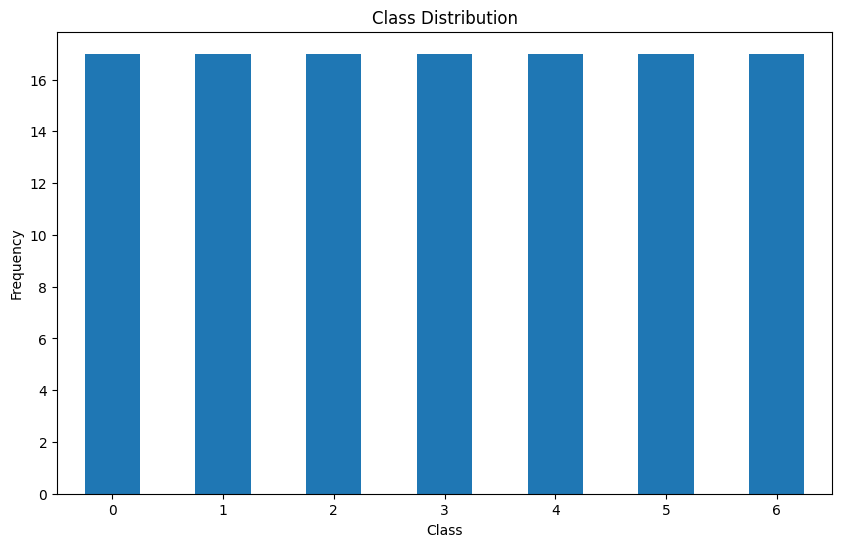

In [30]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_UnderResampled, y_UnderResampled = rus.fit_resample(X, y)

class_counts = y_UnderResampled.value_counts()
print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Creating a full pipeline from A-Z

In [31]:
from sklearn.pipeline import Pipeline as Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

#Examples of preprocessing
NUMERIC_TRANSFORMER = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('polynomial_features', PolynomialFeatures(degree=2))
])

PREPROCESSOR = ColumnTransformer(
    transformers=[
        ('num', NUMERIC_TRANSFORMER, list(X.columns))
    ])

In [32]:
def make_pipeline_with_custom_steps(preprocessor: TransformerMixin = None,
                                    poly_degree: int = None,
                                    sampler: BaseEstimator = None,
                                    base_estimator: BaseEstimator = None) -> ImbPipeline:
    """
    Creates a pipeline with specified preprocessor, sampler, and estimator.

    Args:
    preprocessor (TransformerMixin): A preprocessing step or None.
    sampler (BaseEstimator): A sampling technique like SMOTE, RandomUnderSampler, or None.
    base_estimator (BaseEstimator): The machine learning estimator.

    Returns:
    ImbPipeline: The constructed pipeline.
    """
    steps = []
    if preprocessor:
        steps.append(('preprocessor', preprocessor))
    if poly_degree is not None:
        steps.append(('poly_features', PolynomialFeatures(degree=poly_degree)))
    if sampler:
        steps.append(('sampler', sampler))
    if base_estimator:
        steps.append(('classifier', base_estimator))

    return ImbPipeline(steps)

In [33]:
def make_pipeline_with_estimator(base_estimator: BaseEstimator) -> Pipeline:
    return Pipeline(steps=[('preprocessor', PREPROCESSOR),
                           ('classifier', base_estimator)])

In [34]:
import numpy as np
import seaborn as sns

def plot_confusion_matrix_and_report(
    train_confusion_matrix: np.ndarray,
    train_classification_report: str,
    test_confusion_matrix: np.ndarray,
    test_classification_report: str,
    estimator_name: str,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot confusion matrix for train data
    sns.heatmap(
        train_confusion_matrix, annot=True, fmt="d", ax=axs[0]
    )
    axs[0].set_title(f"Train Confusion Matrix ({estimator_name})")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # Plot confusion matrix for test data
    sns.heatmap(test_confusion_matrix, annot=True, fmt="d", ax=axs[1])
    axs[1].set_title(f"Test Confusion Matrix ({estimator_name})")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print(f"{estimator_name} (Train) Classification Report:")
    print(train_classification_report)

    print("========================================")

    print(f"{estimator_name} (Test) Classification Report:")
    print(test_classification_report)


def train_and_evaluate_ImbPipeline(pipeline: ImbPipeline, X, y, plot=True) -> tuple[np.ndarray, str, np.ndarray, str]:
    # Train the model using cross-validation
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=13,
                                                        stratify=y)

    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Evaluate the model on training data
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(
        y_train,
        y_train_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    # Evaluate the model on validation data
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(
        y_test,
        y_test_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    if(plot):
        plot_confusion_matrix_and_report( train_confusion_matrix,
                                        train_classification_report,
                                         test_confusion_matrix,
                                         test_classification_report,
                                         pipeline.named_steps['classifier'].__class__.__name__)

    return (
        train_confusion_matrix,
        train_classification_report,
        test_confusion_matrix,
        test_classification_report,
    )



In [35]:
def train_and_evaluate_sklearnPipeline(pipeline: Pipeline, X, y, plot=True) -> tuple[np.ndarray, str, np.ndarray, str]:
    # Train the model using cross-validation
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=13,
                                                        stratify=y)

    smote = SMOTE(random_state=42)
    X_smoted, y_smoted = smote.fit_resample(X_train, y_train)

    pipeline.fit(X_smoted, y_smoted)
    y_train_pred = pipeline.predict(X_train)

    # Evaluate the model on training data
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(
        y_train,
        y_train_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    # Evaluate the model on validation data
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(
        y_test,
        y_test_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    if(plot):
        plot_confusion_matrix_and_report( train_confusion_matrix,
                                        train_classification_report,
                                         test_confusion_matrix,
                                         test_classification_report,
                                         pipeline.named_steps['classifier'].__class__.__name__)

    return (
        train_confusion_matrix,
        train_classification_report,
        test_confusion_matrix,
        test_classification_report,
    )

# Creating the Sklearn Pipeline

### Logistic Regression Pipeline with StandardScaler and SMOTE sampling

In [36]:
MLP = MLPClassifier(
    hidden_layer_sizes=(300,300,),
    learning_rate_init=0.3,
    momentum=0.2,
    max_iter=1000,
    random_state=random_seed,
    verbose=True,
    activation="relu"
)
KNN = KNeighborsClassifier(n_neighbors=7)

### KNN

In [37]:
# sklearnPipeline_KNN = make_pipeline_with_estimator(KNN)
# train_and_evaluate_sklearnPipeline(sklearnPipeline_KNN, X, y)

### Decision Tree

In [38]:
sklearnPipeline_DT = make_pipeline_with_estimator(DecisionTreeClassifier(random_state=42))
# train_and_evaluate_sklearnPipeline(sklearnPipeline_DT, X, y)

### Logistic Regression

In [39]:
sklearnPipeline_LogRes = make_pipeline_with_estimator(LogisticRegression(random_state=42, max_iter=2000))
# train_and_evaluate_sklearnPipeline(sklearnPipeline_LogRes, X, y)

# Creating the Imblearn Pipeline

In [40]:
ImbPipeline_LogRes = make_pipeline_with_custom_steps(preprocessor=StandardScaler(),
    poly_degree=2,
    sampler=SMOTE(random_state=42),
    base_estimator=LogisticRegression(random_state=42, max_iter=2000))
# train_and_evaluate_ImbPipeline(ImbPipeline_LogRes, X, y)


## Ensembling

In [52]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from typing import Dict

def get_ensemble(name_to_clf: Dict[str, BaseEstimator]) -> VotingClassifier:
    ensemble = VotingClassifier(
        estimators=list(name_to_clf.items()),
        voting="hard",
    )

    return ensemble

ENSEMBLE = get_ensemble({
    "LR": LogisticRegression(random_state=42, max_iter=2000),
    "KNN": KNN,
    # "GB": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "NBC": GaussianNB(),
})


In [53]:
(
    ensemble_train_conf,
    ensemble_train_clf_report,
    ensemble_test_conf,
    ensemble_test_clf_report,
) = train_and_evaluate_model(
    ENSEMBLE, X_train, y_train, X_test, y_test
)

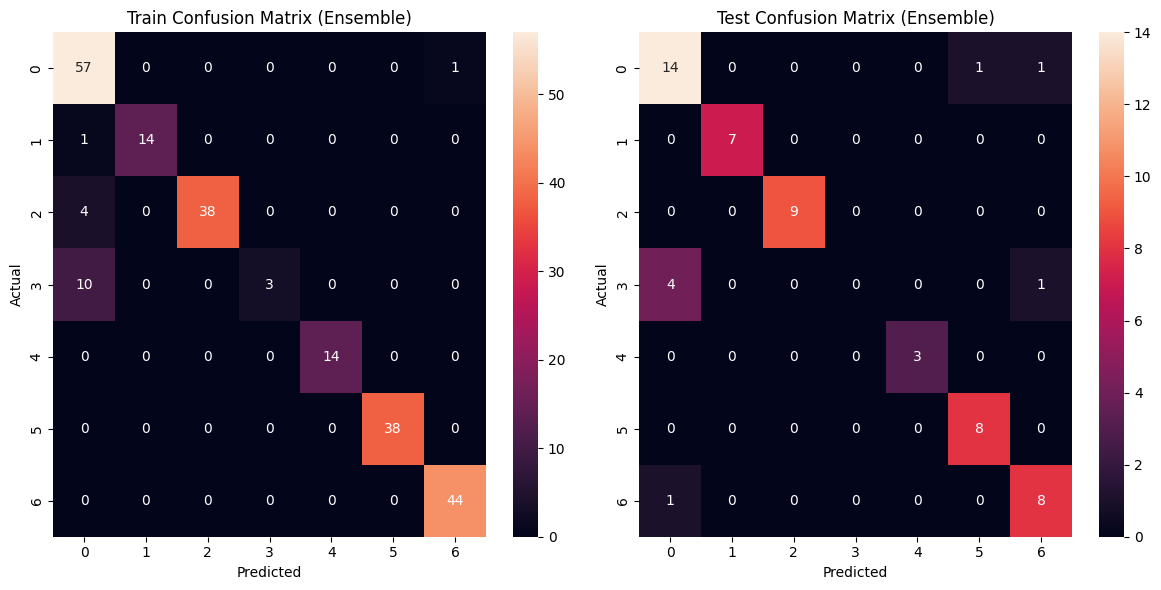

Ensemble (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.79      0.98      0.88        58
 B-CELL_ALL_TCF3-PBX1       1.00      0.93      0.97        15
  B-CELL_ALL_HYPERDIP       1.00      0.90      0.95        42
      B-CELL_ALL_HYPO       1.00      0.23      0.38        13
       B-CELL_ALL_MLL       1.00      1.00      1.00        14
     B-CELL_ALL_T-ALL       1.00      1.00      1.00        38
B-CELL_ALL_ETV6-RUNX1       0.98      1.00      0.99        44

             accuracy                           0.93       224
            macro avg       0.97      0.86      0.88       224
         weighted avg       0.94      0.93      0.92       224

Ensemble (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.74      0.88      0.80        16
 B-CELL_ALL_TCF3-PBX1       1.00      1.00      1.00         7
  B-CELL_ALL_HYPERDIP       1.00   

In [55]:
plot_confusion_matrix_and_report(
    ensemble_train_conf,
    ensemble_train_clf_report,
    ensemble_test_conf,
    ensemble_test_clf_report,
    "Ensemble",
)

## HyperParameter Tuning

In [54]:
from sklearn.model_selection import RandomizedSearchCV

def random_search_hyperparameters(estimator: BaseEstimator, param_distributions: Dict, n_iter=10):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
    )

    return random_search

## TODO

- [ ] Fix random oversampling pipeline
- [ ] Rerun Ensemble with the pipeline
- [ ] Run random search param tuning with the pipeline

In [56]:
dill.dump_session(SESSION_FILE)